<div style="text-align: center; font-size: 45px; font-weight: bold"> Machine Learning and Radiomics for Meningioma Grade Prediction </div>

# Library importation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm 


# Model Preprocessors
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Classifier optimizers
from sklearn.model_selection import GridSearchCV

# Model Evaluation Metrics
from sklearn.utils.validation import check_is_fitted 
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, recall_score,
                             confusion_matrix, f1_score, classification_report)
from sklearn.model_selection import cross_val_score

# Dataset Description

- **Source:** Pre-operative MRI scans from The Cancer Imaging Archive (TCIA)
- **License:** Restricted license agreement
- **Cohort:** 94 patients diagnosed with meningioma (2010-2019)
- **Tumor Grade:** Grade I and Grade II (WHO 2016 classification) - Grade III excluded due to rarity
- **Format:** CSV file containing radiomics features

This dataset offers a view into meningioma, a brain tumor. It meticulously documents 94 patients diagnosed between 2010 and 2019 (excluding rare Grade III cases). Their pre-operative MRI scans, brimming with detailed imagery, provide the foundation for analysis.

# Wrangle Data

In [7]:
def wrangle(file_path):
    data = pd.read_csv(file_path)
    
    # drop the subject column which identifies each entry
    data = data.drop(columns="Subjects")
    
    # get basic information of dataset
    grade_classes = data["Grade"].unique()
    dataset_config = data.shape

    print("Grade Classes: ", grade_classes)
    print("Data Config: ", dataset_config)
    
    # return processed data
    return data

df_main = wrangle("Dataset _01.csv")

Grade Classes:  [1 0]
Data Config:  (94, 49)


# Preliminary data analysis

## Data Preprocessing and Visualization

In [10]:
# get more information on the dataset
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 49 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Grade                                                   94 non-null     int64  
 1   original_firstorder_Skewness_t1c                        94 non-null     float64
 2   original_glrlm_HighGrayLevelRunEmphasis_t1c             94 non-null     float64
 3   wavelet-LLH_glszm_GrayLevelNonUniformityNormalized_t1c  94 non-null     float64
 4   wavelet-LHL_glszm_GrayLevelNonUniformityNormalized_t1c  94 non-null     float64
 5   wavelet-HLL_glszm_GrayLevelNonUniformityNormalized_t1c  94 non-null     float64
 6   wavelet-HLH_firstorder_Mean_t1c                         94 non-null     float64
 7   wavelet-HLH_glszm_ZoneEntropy_t1c                       94 non-null     float64
 8   wavelet-HHL_glszm_HighGrayLevelZoneEmphasi

### Shorten Column Names

In [12]:
df = df_main.copy()
df.columns = df.columns.str.replace("-","_")

import re
pattern1 = r"(original|wavelet|glrlm|glszm|gldm)_([^_]+)_([^_]+)_t(1c|2f)"
pattern2 = r"(original|wavelet|glrlm|glszm|gldm)_([^_]+)_([^_]+)_([^_]+)_t(1c|2f)"

for col in df.columns:
    match = re.match(pattern1, col)
    if match:
        # Extract relevant parts from the match object
        prefix, feature1, feature2, suffix = match.groups()
        # Define your abbreviation logic (replace with your desired format)
        abbr_name = f"{prefix[0].upper()}_{feature1[:4].upper()}_{feature2[:4].upper()}_{suffix}"
        # Rename the column
        df.rename(columns={col: abbr_name}, inplace=True)
    
    match = re.match(pattern2, col)
    if match:
        # Extract relevant parts from the match object
        prefix, feature1, feature2, feature3, suffix = match.groups()
        # Define your abbreviation logic (replace with your desired format)
        abbr_name = f"{prefix[0].upper()}_{feature1[:4].upper()}_{feature2[:4].upper()}_{feature3[:8].upper()}_{suffix}"
        # Rename the column
        df.rename(columns={col: abbr_name}, inplace=True)

# Print the data with new column names (optional)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Grade                   94 non-null     int64  
 1   O_FIRS_SKEW_1c          94 non-null     float64
 2   O_GLRL_HIGH_1c          94 non-null     float64
 3   W_LLH_GLSZ_GRAYLEVE_1c  94 non-null     float64
 4   W_LHL_GLSZ_GRAYLEVE_1c  94 non-null     float64
 5   W_HLL_GLSZ_GRAYLEVE_1c  94 non-null     float64
 6   W_HLH_FIRS_MEAN_1c      94 non-null     float64
 7   W_HLH_GLSZ_ZONEENTR_1c  94 non-null     float64
 8   W_HHL_GLSZ_HIGHGRAY_1c  94 non-null     float64
 9   W_HHH_FIRS_SKEWNESS_1c  94 non-null     float64
 10  W_HHH_GLSZ_SIZEZONE_1c  94 non-null     float64
 11  O_GLSZ_HIGH_2f          94 non-null     float64
 12  W_LHH_GLSZ_GRAYLEVE_2f  94 non-null     float64
 13  W_LHH_GLSZ_SIZEZONE_2f  94 non-null     float64
 14  W_LHH_GLSZ_SMALLARE_2f  94 non-null     floa

### Statistical description of data

In [14]:
pd.DataFrame(df.describe())

,Grade,O_FIRS_SKEW_1c,O_GLRL_HIGH_1c,W_LLH_GLSZ_GRAYLEVE_1c,W_LHL_GLSZ_GRAYLEVE_1c,W_HLL_GLSZ_GRAYLEVE_1c,W_HLH_FIRS_MEAN_1c,W_HLH_GLSZ_ZONEENTR_1c,W_HHL_GLSZ_HIGHGRAY_1c,W_HHH_FIRS_SKEWNESS_1c,...,O_GLRL_SHOR_2f,W_LHH_GLSZ_GRAYLEVE_2f,W_LHH_GLSZ_SMALLARE_2f,W_HLL_GLRL_LONGRUNL_2f,W_HLL_GLRL_LONGRUNH_2f,W_LHL_GLRL_LONGRUNH_2f,W_HLL_GLRL_RUNENTRO_2f,W_LLH_GLRL_RUNENTRO_2f,W_LHL_GLRL_LONGRUNL_2f,W_LLH_GLDM_SMALLDEP_2f
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,9.400000e+01,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.436170,-0.243500,2.899225,0.635435,0.623576,0.632099,0.002783,2.236178,2.489702,-0.065559,...,0.356015,0.232594,5.356573e-01,9.128278,29.574805,25.864903,3.188343,3.578411,7.785921,0.006517
std,0.498568,0.768804,1.438076,0.115019,0.107621,0.103743,0.007713,0.622811,0.411192,0.123249,...,0.218767,0.020321,1.701179e-01,2.654790,8.857305,7.693632,0.211179,0.216781,2.047935,0.001778
min,0.000000,-2.052332,1.000000,0.500000,0.500000,0.500000,-0.029598,1.000000,1.500000,-0.449264,...,0.090007,0.160000,7.650000e-08,2.404321,9.727375,11.357795,2.469126,2.652987,3.624379,0.004615
25%,0.000000,-0.774200,1.000000,0.535693,0.531336,0.537190,0.000156,1.849679,2.206818,-0.118660,...,0.148213,0.222222,4.542996e-01,7.289214,22.739840,20.538101,3.042866,3.472482,6.271558,0.005493
50%,0.000000,-0.243948,3.972175,0.618594,0.603306,0.623032,0.001359,2.250101,2.500000,-0.049542,...,0.345379,0.240000,5.874852e-01,9.458491,31.323187,25.725575,3.247389,3.613757,7.618922,0.005912
75%,1.000000,0.178430,3.994126,0.719002,0.702479,0.708371,0.003247,2.571382,2.795946,0.001109,...,0.498012,0.248106,6.493523e-01,10.430441,34.985642,30.404355,3.340362,3.722113,9.105742,0.006939
max,1.000000,2.244620,3.999413,0.950033,0.905000,0.871581,0.037356,4.478859,3.500000,0.335625,...,1.000336,0.250000,7.897026e-01,15.224847,51.529881,48.882039,3.504120,3.973320,13.499614,0.016829


**Observations & Description**

Looking at the data the focus appears to lie on tumor grade (recorded for each patient), categorized based on the 2016 World Health Organization system. But draws it strength from the use of radiomics features. The feature in the Grade column are numbers describing the tumor's categories as it is an int64 data type. 
1. The dataset appears to be well typed and properly 
2. It contains 94 entries (data points). 
3. Each entry has 50 features (columns).
4. Datatypes are Object, Int64 and float64.
5. No missing value observed in this dataset.
6. One feature identifies the subject of the data point.
7. Another feature indicates the grade. 

**Limitations of Dataset**

The dataset has a Grade feature containing only Grade I and Grade II tumors:

- **Limited Generalizability**: Meningiomas can be classified into Grades I, II, and III. But this dataset excludes Grade III, the most aggressive form of Meningiomas. The models developed from this might not generalize well to identifying these high-risk tumors like the Grade III tumors.

- **Focus on Benign and Atypical**: The data focuses on differentiating between benign (Grade I) and atypical (Grade II) meningiomas. This can be valuable for specific clinical questions, but it limits the ability to predict the full spectrum of meningioma behavior.

- **Selection Bias**: The process of selecting only Grades I and II tumors might introduce bias. Grade III cases were excluded due to their rare occurrence. This can skew the model's understanding of the disease.

- **Reduced Power for Machine Learning**: Having only two classes (Grade I and II) can limit the ability of machine learning models to learn complex patterns. More classes (including Grade III) could provide a richer dataset for model development.



## Correlation Analysis

### Multicolinearity Detection

**Variance Inflation Factor (VIF)**: A variance inflation factor (VIF) is a measure of the amount of multicollinearity in regression analysis. VIF is used to identify the correlation of one independent variable with a group of other variables.

$\displaystyle VIF_{i} = (\frac{1}{1-R^2{i}})$

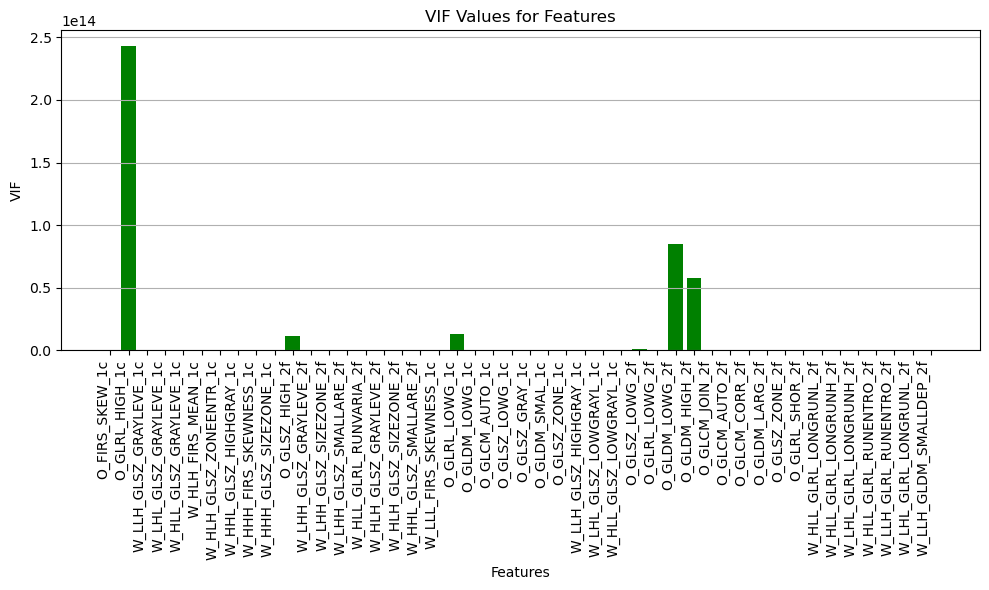

In [19]:
X = df.drop(columns="Grade")

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))]

# Visualize using a Bar chart
plt.figure(figsize=(10, 6))
plt.bar(vif_data["feature"], vif_data["VIF"], color="g")
plt.xlabel("Features")
plt.ylabel("VIF")
plt.xticks(rotation=90, ha='right')  # Rotate feature names for readability
plt.title("VIF Values for Features")
plt.grid(axis='y')  # Add gridlines on the y-axis
plt.tight_layout()
plt.show()

### Correlation Matrix Plot

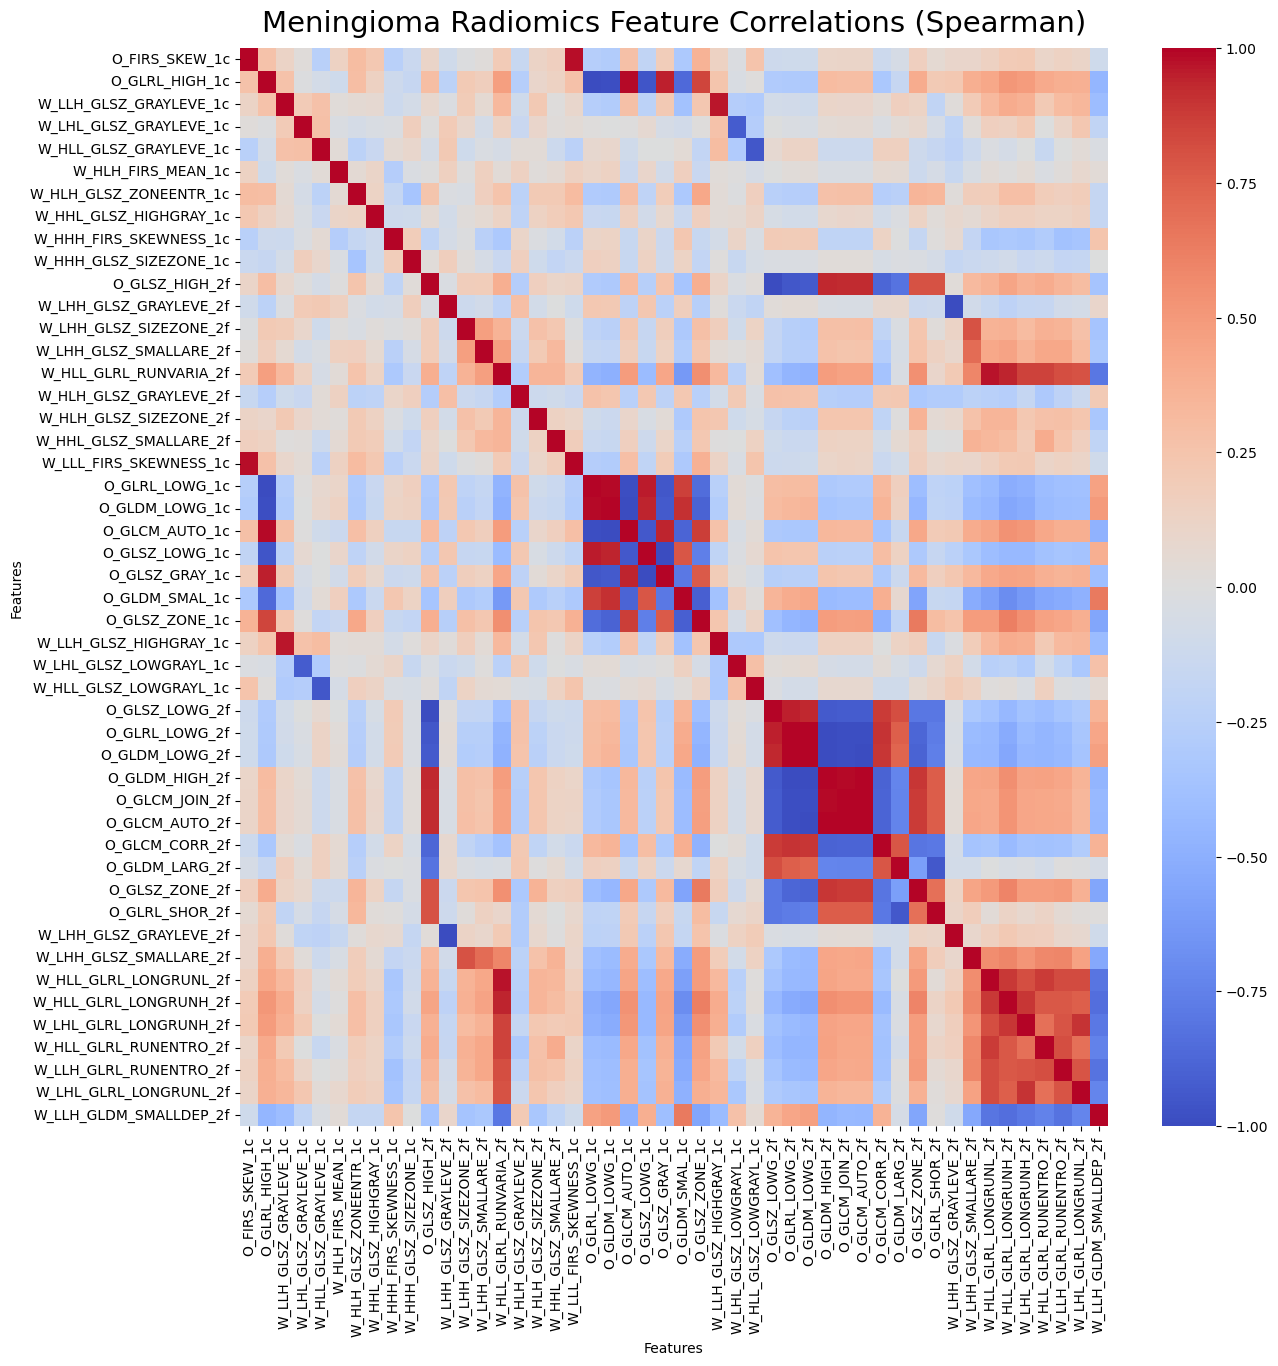

In [21]:
# Calculate correlation matrix
correlation_matrix = (df.select_dtypes("number")
                      .drop(columns=["Grade"])
                      .corr(method='spearman'))  # Use spearman for non-normal data

# Create a new figure for plotting
plt.figure(figsize=(14, 14))

# Create heatmap using seaborn
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', vmin = -1, vmax = 1)  # 'coolwarm' for diverging colors

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
# plt.title('Meningioma Radiomics Feature Correlations (Spearman)')
heatmap.set_title('Meningioma Radiomics Feature Correlations (Spearman)', fontdict = {'fontsize' : 21}, pad = 12)

# Show the plot
plt.show()

From the correlation matrix we can observe that a number of the features highly correlate with each other which can likely introduce some data redundancy and increased cost of training.

### Remove Features with Correlation > 0.95

In [24]:
# Create correlation matrix
corr_matrix = df.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop highly correlated features
df.drop(to_drop, axis=1, inplace=True)

# Print the reduced DataFrame shape
df.shape

(94, 30)

## Outliers Detection

### Boxplot Visualization

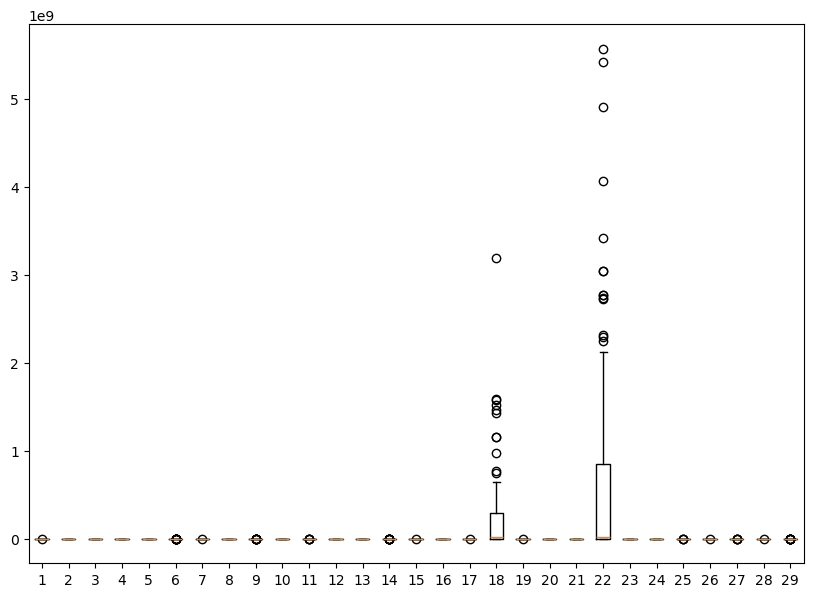

In [27]:
# Create a figure
fig = plt.figure(figsize=(10, 7))

# Plot the box plot
plt.boxplot(df.iloc[:,1:50])

# Show the plot
plt.show()

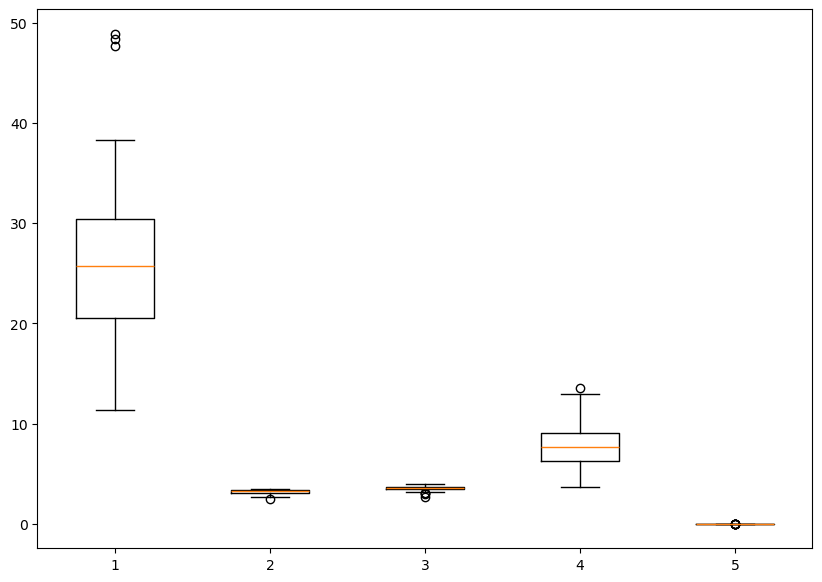

In [28]:
# Create a figure
fig = plt.figure(figsize=(10, 7))

# Plot the box plot
plt.boxplot(df.iloc[:,25:30])

# Show the plot
plt.show()

**Observation:**

From this boxplot the presence of outliers in 26 columns or features can be observed. The “box” indicates the interquartile range (from the lower quartile to the upper quartile, with the middle indicating the median data value) and any outliers will be shown outside of the “whiskers” of the plot (Sequitin, 2021) as seen in the plot above, each side representing the minimum and maximum values of the dataset, respectively. If the box skews closer to the maximum whisker, the prominent outlier would be the minimum value and vise versa (Sequitin, 2021).

Taking a closer look at the most prominent variables (`original_glszm_ZoneVariance_t1c` and `original_glszm_ZoneVariance_t2f `), we noticed that the data is skewed closer to the minimum whisker indicating prominent outliers closer to the maximum whisker. We can explore further to detect an other significant outliers in the dataset. Below are selected few prominent boxplots.

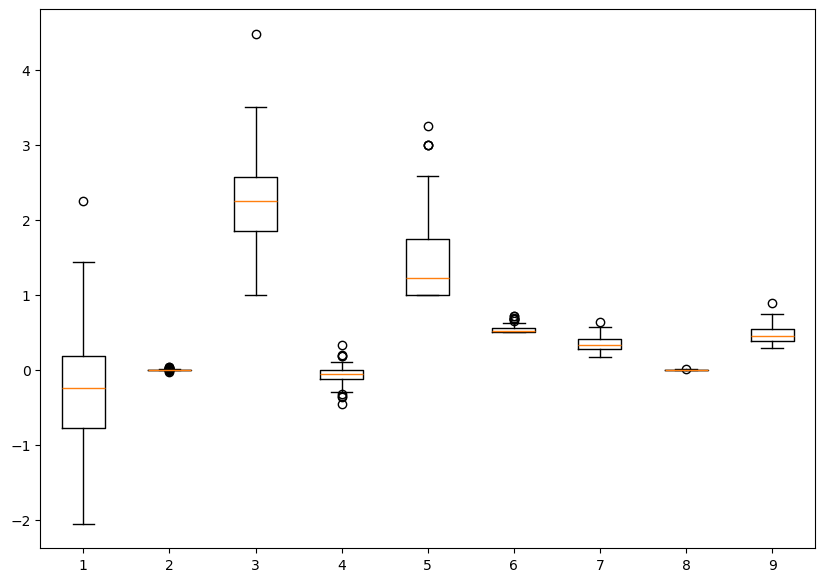

In [30]:
# Create a figure
fig = plt.figure(figsize=(10, 7))

# Plot the box plot
plt.boxplot(df.iloc[:,[1, 6, 7, 9, 11, 14, 15, 17, 19]])

# Show the plot
plt.show()

Some features, like skewness, reveal the symmetry of intensity distribution. Others, like Gray Level Non-Uniformity, capture how intensity fluctuates across the image. There's even a category that analyzes how often specific intensity patterns repeat.

With over 50 features in total, this dataset provides a detailed statistical description of each tumor's MRI. However, it's important to consider potential outliers in the data, as shown by the exploration for outlier above using the boxplot, which shows that a significant of the features showed sign of outlier of which many were significant with univariate outliers (Sequitin, 2021). Statistical measures like standard deviation and interquartile range (IQR) can also help identify data points that fall significantly outside the expected range. The question is how do we threat these outliers? These outliers may require further investigation to confirm and ensure data quality while avoiding skewing analysis results.

This data can help us to delve deeper into meningiomas, potentially to uncover hidden patterns or connections between textural properties and factors like tumor grade.

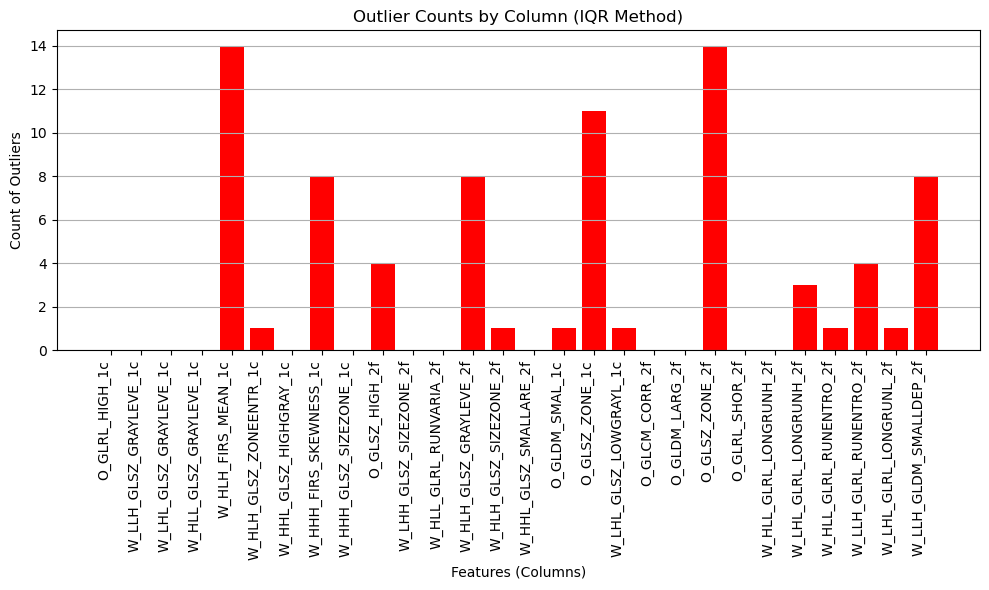

In [32]:
def get_iqr_outliers(data, columns):
    """
    Calculates IQR outliers for specified columns in a pandas DataFrame.
    
    Args:
      data (pandas.DataFrame): The DataFrame containing the data.
      columns (list): A list of column names to calculate IQR outliers for.
      
    Returns:
      dict: A dictionary where keys are column names and values are lists of outlier indexes.
    """
    outliers = {}
    data.reset_index(drop=True, inplace=True)  # Reset index, dropping the old index
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_indices = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index
        
        outliers[col] = outlier_indices.tolist()  # Convert to list for compatibility
    return outliers

# Apply the function
outlier_dict = get_iqr_outliers(df.iloc[:,2:50], df.columns[2:50])

# Visualize
# Create a list to store outlier counts for each column
outlier_counts = []
for col, outliers in outlier_dict.items():
    outlier_counts.append(len(outliers))

# Create a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Figure size
plt.bar(outlier_dict.keys(), outlier_counts, color="r")
plt.xlabel("Features (Columns)")
plt.ylabel("Count of Outliers")
plt.title("Outlier Counts by Column (IQR Method)")
plt.xticks(rotation=90, ha='right')  # Rotate column names for readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Outliers and their causes:**

This analysis delves into the challenges of outlier data points in the context of binary classification for brain tumors. The goal is to differentiate Grade 1 (negative class) and Grade 2 (positive class) meningiomas using radiomics features extracted from MRI scans (Vijithananda et al., 2022). he dataset exhibits a high number of outliers across features, exceeding half of the total features (26 out of 50). These outliers can potentially influence the performance of machine learning models for binary classification (Jalali & Kaur, 2020). Here's a breakdown of possible reasons for outliers:

Several factors could contribute to these outliers. Measurement errors, although less likely due to the sheer number of outliers (Chowdhary & Acharjya, 2020), remain a possibility. However, it's more probable that these outliers represent a combination of natural variations in meningioma characteristics and potential biases introduced during data collection. Meningiomas exhibit a wide spectrum of features, and some tumors might possess genuinely unusual characteristics compared to the majority (Vijithananda et al., 2022). Additionally, the data acquisition process might have inadvertently favored certain meningioma types, leading to outliers representing less common features.

To effectively address these outliers, a multi-pronged approach is necessary. First, a thorough investigation is crucial.  Techniques like the IQR method can identify specific features and patients associated with outliers (Galarnyk & Whitfield, 2022).  MRI scans of these patients should be reviewed to identify any abnormalities that might explain the extreme values.  Furthermore, data entry errors should be checked for these specific data points.

Second, incorporating domain expertise is vital. Consulting with medical professionals and researchers familiar with meningiomas can help determine if the outliers represent genuine biological variations or potential errors (Greener et al., 2021).  Their knowledge can shed light on the biological plausibility of these extreme values.

Third, a sensitivity analysis is recommended. This involves temporarily removing the outliers and observing the impact on the performance of machine learning models. This analysis helps assess how susceptible the models are to the presence of outliers (Prakhar, 2018).

Traditional outlier removal techniques might not be the optimal approach in this case.  Given the potential biological significance of some outliers, especially for tumors bordering on Grade 2 aggressiveness, removing them entirely could lead to a loss of valuable information.  Instead, the focus should be on employing machine learning models that are inherently robust to outliers.  These robust models can effectively learn from the data  without being unduly influenced by the presence of outliers (considerations from Modaresi & Araghinejad, 2014, could be helpful here).


**Proposed ways to handle outliers:**

* Winsorization: This technique replaces extreme values with values at the tails of the distribution (e.g., replacing with percentiles).
* Robust models: Some machine learning models are more robust to outliers than others. We would consider exploring models with less sensitive to outliers since we do not intend removing them because of their sensitivity in our classification problem.
* Removal: After outliers confirmation as errors or biologically implausible, We can consider removing them. However, this would be done cautiously, especially with our limited dataset.
* Decision based on severity: For mild outliers, especially if they align with potentially aggressive tumors, keeping them might be valuable for capturing the full spectrum of the disease of the extreme grade 2.

A nuanced approach is required to address outliers in this specific context of brain tumor classification.  By combining in-depth investigation, domain expertise, sensitivity analysis, and the utilization of robust models, we can maintain data integrity while optimizing the performance of the classification model for differentiating Grade 1 and Grade 2 brain tumors. This approach ensures that the model can effectively capture the full spectrum of the disease, including potential variations within the Grade 2 classification.

## Class balance (Grade Feature)

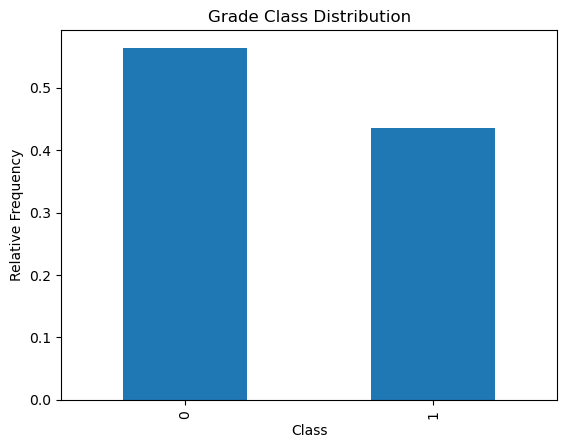

In [35]:
df["Grade"].value_counts(normalize=True).plot(
    kind="bar", 
    xlabel="Class", 
    ylabel="Relative Frequency", 
    title="Grade Class Distribution"
)

plt.show()

### Majority and Minority Class

In [37]:
majority_class_prop, minority_class_prop = df["Grade"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.5638297872340425 0.43617021276595747


# Data Standardization

We would standardize the data to ensure that all features have a mean of 0 and a standard deviation of 1. This step helps mitigate the effects of outliers and ensures that features are on a comparable scale. Standardization is particularly useful for algorithms sensitive to the radiomic feature scales, such as K-Nearest Neighbors and Support Vector Machines (Prakhar, 2018; Rosenblatt et al., 2023).

This step ensures the training data has a mean of 0 and standard deviation of 1. By standardizing training and testing data normalize the trainin dataset (Greener et al., 2021).

In [40]:
# Initialize scaler and fit on training data (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection

## Split Dataset

Create feature matrix `X` and target vector `y` with `Grade` as our target class

In [44]:
target = "Grade"
X = df.drop(columns=target)
y = df[target]

print("Dimension of X: ", X.shape)
print("Dimension of y: ", y.shape)

Dimension of X:  (94, 29)
Dimension of y:  (94,)


## Filter-Based Method (SelectKBest)

In [46]:
from sklearn.feature_selection import SelectKBest, f_classif

# SelectKBest for classification tasks (use f_classif)
selector = SelectKBest(f_classif, k=10)  # f_classif for classification, k=number of features to select
X_filtered = selector.fit_transform(X, y)

print("Dimension of X: ", X_filtered.shape)
print("Dimension of y: ", y.shape)

Dimension of X:  (94, 10)
Dimension of y:  (94,)


## SMOTE 

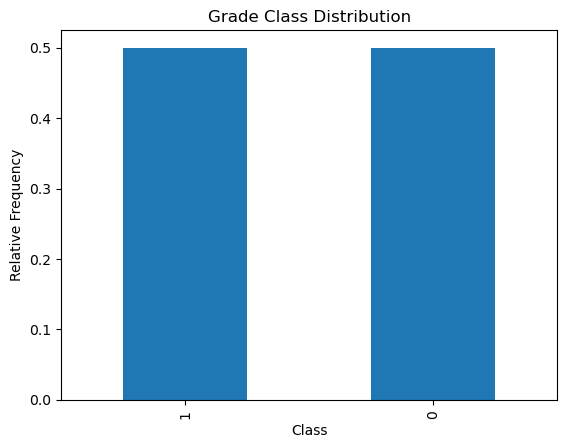

In [48]:
from imblearn.over_sampling import SMOTE

# Create an SMOTE instance
smote = SMOTE(random_state=42)  # Set a random state for reproducibility

# Oversample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_filtered, y)

y_resampled.value_counts(normalize=True).plot(
    kind="bar", 
    xlabel="Class", 
    ylabel="Relative Frequency", 
    title="Grade Class Distribution"
)

plt.show()

# Model Training

## Randomized Train-Test Split
Split the data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility (scikit-learn, 2024).


In [51]:
# Randomized train-test split is suitable for categorical classification
# since no choronogical order is required.
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42,
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (79, 10)
y_train shape: (79,)
X_test shape: (27, 10)
y_test shape: (27,)


## Setting Baseline Accuracy

In [53]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5316


## Build Classifier Models

### Logistic Regression Classifier (LG)

In [56]:
# Build model
lg_model = LogisticRegression(max_iter=1000)

# Fit model to training data
lg_model.fit(X_train, y_train)

# Predict using trained model
y_pred_lg = lg_model.predict(X_test)

# Evaluate model Accuracy
accuracy = accuracy_score(y_test, y_pred_lg)
print("Accuracy LG model:", accuracy)

Accuracy LG model: 0.5555555555555556


### Random Forest Classifier (RDF)

In [58]:
# Define a model
rdf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model to training data
rdf_model.fit(X_train, y_train)

# Predict using trained model
y_pred_rdf = rdf_model.predict(X_test)

# Evaluate model Accuracy
accuracy = accuracy_score(y_test, y_pred_rdf)
print("Accuracy RDF model:", accuracy)

Accuracy RDF model: 0.7037037037037037


### Support Vector Machine Classifier (SVC)

In [60]:
# Define a model
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

# Fit model to training data
svc_model.fit(X_train, y_train)

# Predict using trained model
y_pred_svc = svc_model.predict(X_test)

# Evaluate model Accuracy
accuracy = accuracy_score(y_test, y_pred_svc)
print("Accuracy SVC model:", accuracy)

Accuracy SVC model: 0.5925925925925926


# Model Evaluation

## ROC Curve and AUC Score:

Logistic Regression ROC AUC Score: 0.5340909090909092
Random Forest ROC AUC Score: 0.7840909090909091
Support Vector Machine ROC AUC Score: 0.6818181818181819


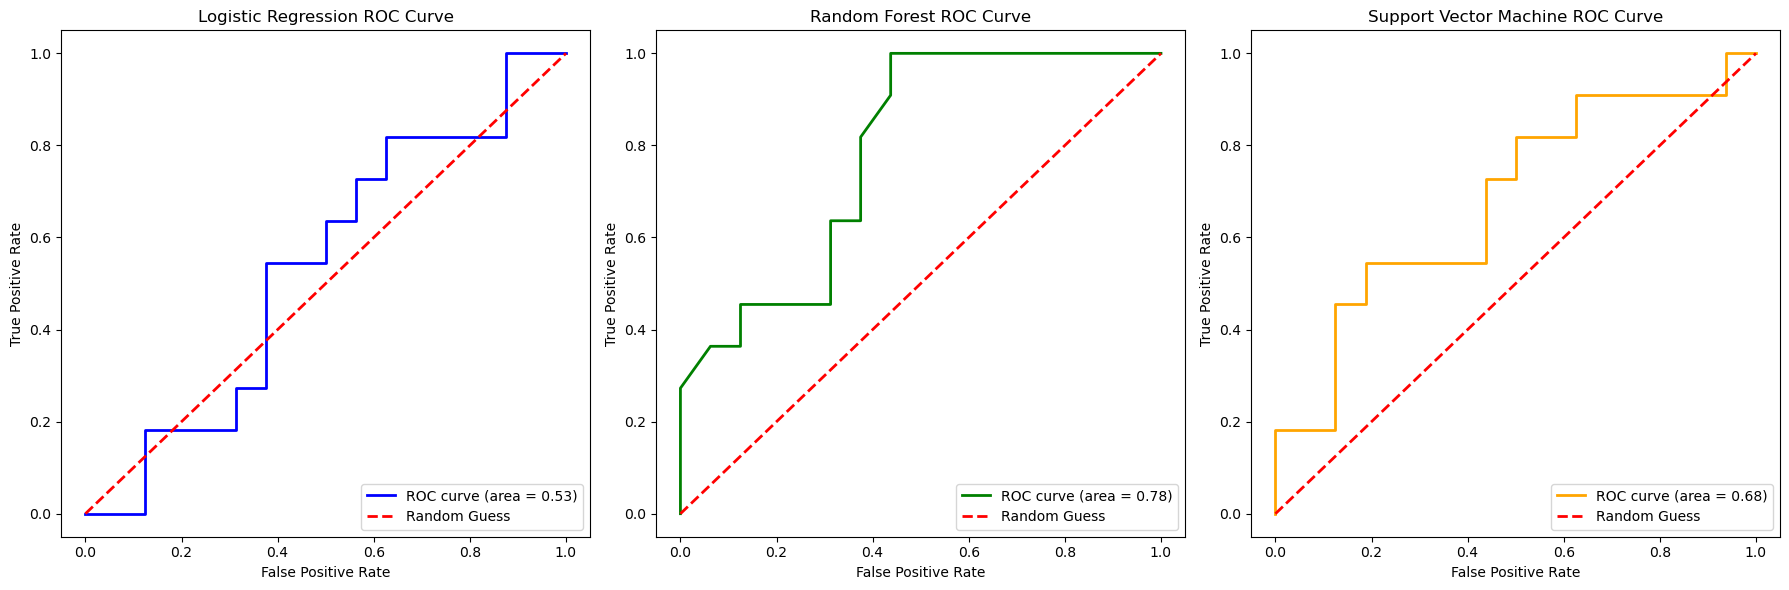

In [63]:
# Predict probabilities of the positive class (class 1) using the trained models
y_pred_prob_lg = lg_model.predict_proba(X_test)[:, 1]
y_pred_prob_rdf = rdf_model.predict_proba(X_test)[:, 1]
y_pred_prob_svc = svc_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob_lg)
fpr_rdf, tpr_rdf, thresholds_rdf = roc_curve(y_test, y_pred_prob_rdf)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_prob_svc)

# Calculate the Area Under the ROC Curve (ROC AUC) score
roc_auc_lg = roc_auc_score(y_test, y_pred_prob_lg)
roc_auc_rdf = roc_auc_score(y_test, y_pred_prob_rdf)
roc_auc_svc = roc_auc_score(y_test, y_pred_prob_svc)

print("Logistic Regression ROC AUC Score:", roc_auc_lg)
print("Random Forest ROC AUC Score:", roc_auc_rdf)
print("Support Vector Machine ROC AUC Score:", roc_auc_svc)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot ROC curve for Logistic Regression
axes[0].plot(fpr_lg, tpr_lg, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lg)
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Logistic Regression ROC Curve')
axes[0].legend(loc='lower right')

# Plot ROC curve for Random Forest
axes[1].plot(fpr_rdf, tpr_rdf, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rdf)
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Random Forest ROC Curve')
axes[1].legend(loc='lower right')

# Plot ROC curve for Support Vector Machine
axes[2].plot(fpr_svc, tpr_svc, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
axes[2].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Support Vector Machine ROC Curve')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()


## Confusion Matrix

Logistic Regression Confusion Matrix: [[ 6 10]
 [ 2  9]]
Random Forest Confusion Matrix: [[10  6]
 [ 2  9]]
Support Vector Machine Confusion Matrix: [[7 9]
 [2 9]]


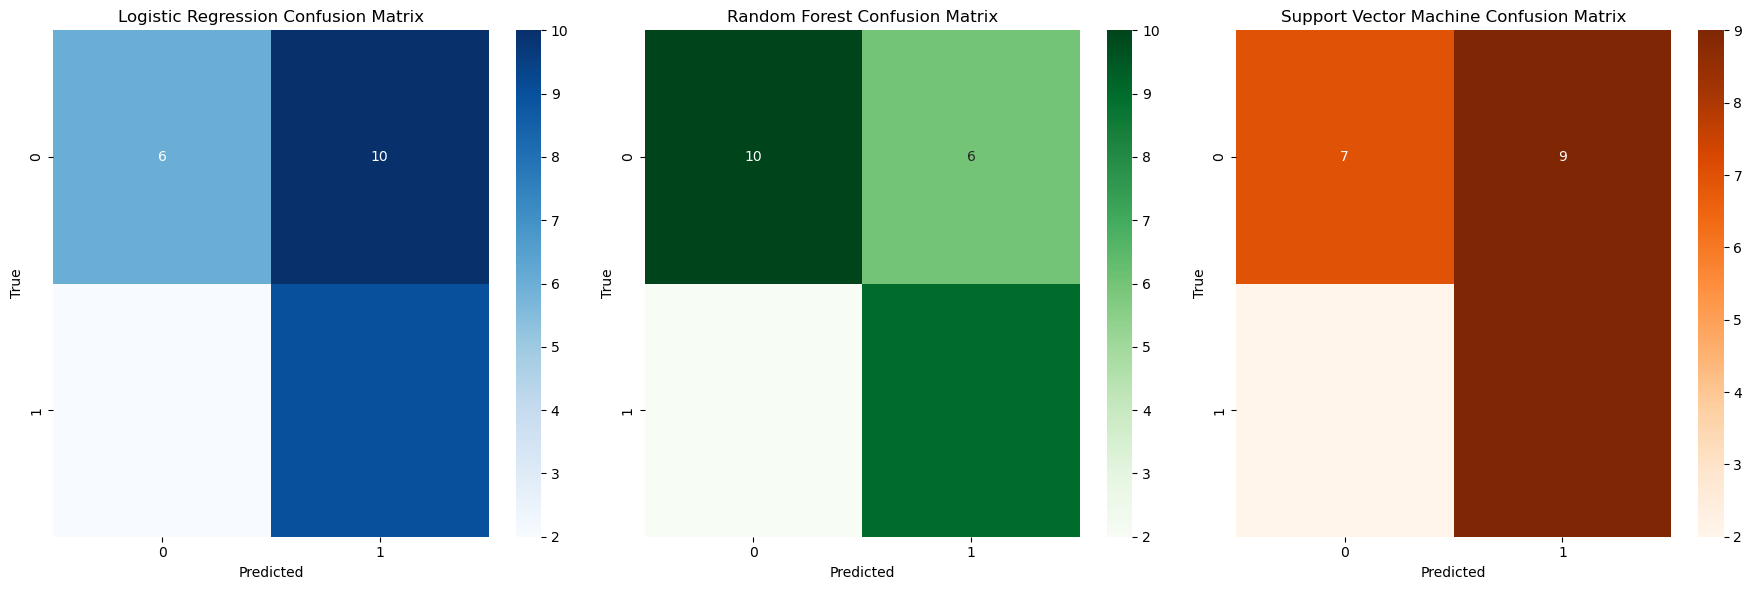

In [65]:
# Confusion Matrix for logistic Regression Model
y_pred_lg = lg_model.predict(X_test)
cm_lg = confusion_matrix(y_test, y_pred_lg)

# Confusion Matrix for Random Forest Model
y_pred_rdf = rdf_model.predict(X_test)
cm_rdf = confusion_matrix(y_test, y_pred_rdf)

# Confusion Matrix for Support Vector Machine
y_pred_svc = svc_model.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)

print("Logistic Regression Confusion Matrix:", cm_lg)
print("Random Forest Confusion Matrix:", cm_rdf)
print("Support Vector Machine Confusion Matrix:", cm_svc)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot confusion matrix as heatmap for Logistic Regression
sns.heatmap(cm_lg, annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Logistic Regression Confusion Matrix')

# Plot confusion matrix as heatmap for Random Forest
sns.heatmap(cm_rdf, annot=True, cmap='Greens', fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Random Forest Confusion Matrix')

# Plot confusion matrix as heatmap for Support Vector Machine
sns.heatmap(cm_svc, annot=True, cmap='Oranges', fmt='g', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title('Support Vector Machine Confusion Matrix')

plt.tight_layout()
plt.show()

## F1-Score

Logistic Regression F1-Score: 0.6
Random Forest F1-Score: 0.6923076923076923
Support Vector Machine F1-Score: 0.6206896551724137


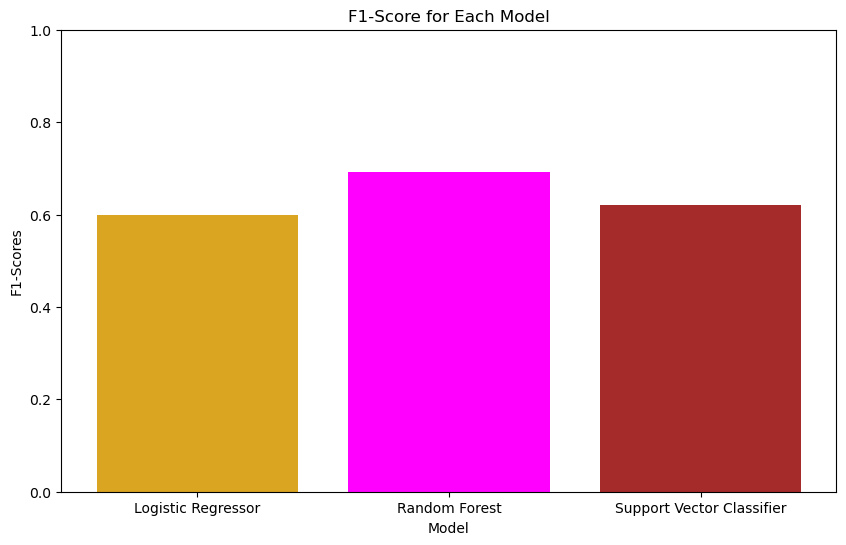

In [67]:
# Logistic Regression F1 - Score
lg_f1 = f1_score(y_test, y_pred_lg) 

# Random Forest F1 - Score
rdf_f1 = f1_score(y_test, y_pred_rdf) 

# Support Vector Machine F1 - Score
svc_f1 = f1_score(y_test, y_pred_svc) 

print("Logistic Regression F1-Score:", lg_f1)
print("Random Forest F1-Score:", rdf_f1)
print("Support Vector Machine F1-Score:", svc_f1)

f1_scores = [lg_f1, rdf_f1, svc_f1]
models = ['Logistic Regressor', 'Random Forest', 'Support Vector Classifier']

# Plot F1-score
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['goldenrod', 'magenta', 'brown'])
plt.xlabel('Model')
plt.ylabel('F1-Scores')
plt.title('F1-Score for Each Model')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

## Cross Validation Score

Logistic Regression Cross-Validation Scores: [0.52631579 0.63157895 0.63157895 0.52631579 0.61111111]
Random Forest Cross-Validation Scores: [0.73684211 0.63157895 0.84210526 0.73684211 0.72222222]
Support Vector Machine Cross-Validation Scores: [0.57894737 0.57894737 0.57894737 0.52631579 0.66666667]


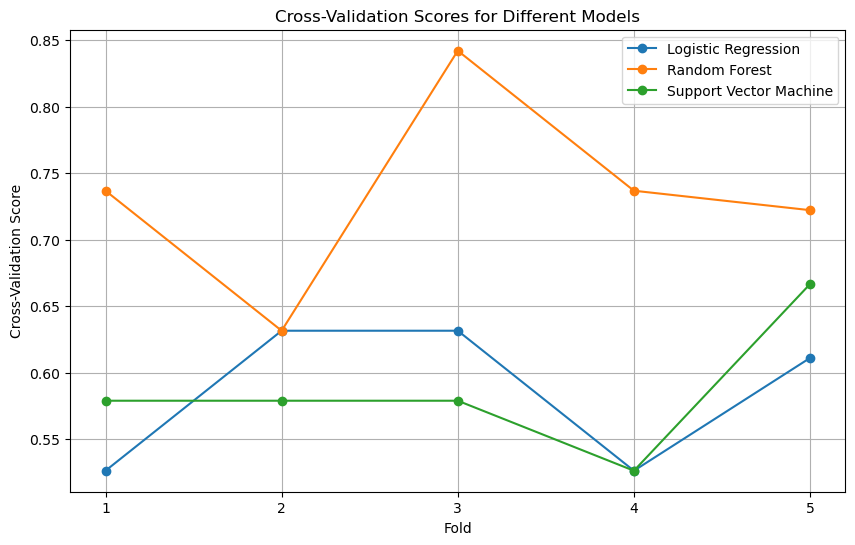

In [69]:
# Logistic Regression Cross-Validation Score
cv_scores_lg = cross_val_score(lg_model, X, y, cv=5)

# Random Forest Cross-Validation Score
cv_scores_rdf = cross_val_score(rdf_model, X, y, cv=5)

# Support Vector Machine Cross-Validation Score
cv_scores_svc = cross_val_score(svc_model, X, y, cv=5)

print("Logistic Regression Cross-Validation Scores:", cv_scores_lg)
print("Random Forest Cross-Validation Scores:", cv_scores_rdf)
print("Support Vector Machine Cross-Validation Scores:", cv_scores_svc)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Logistic Regression Cross-Validation Scores
plt.plot(range(1, 6), cv_scores_lg, marker='o', label='Logistic Regression')

# Plot Random Forest Cross-Validation Scores
plt.plot(range(1, 6), cv_scores_rdf, marker='o', label='Random Forest')

# Plot Support Vector Machine Cross-Validation Scores
plt.plot(range(1, 6), cv_scores_svc, marker='o', label='Support Vector Machine')

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores for Different Models')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Model Recall Score

Logistic Regression Recall: 0.8181818181818182
Random Forest Recall: 0.8181818181818182
Support Vector Machine Recall: 0.8181818181818182


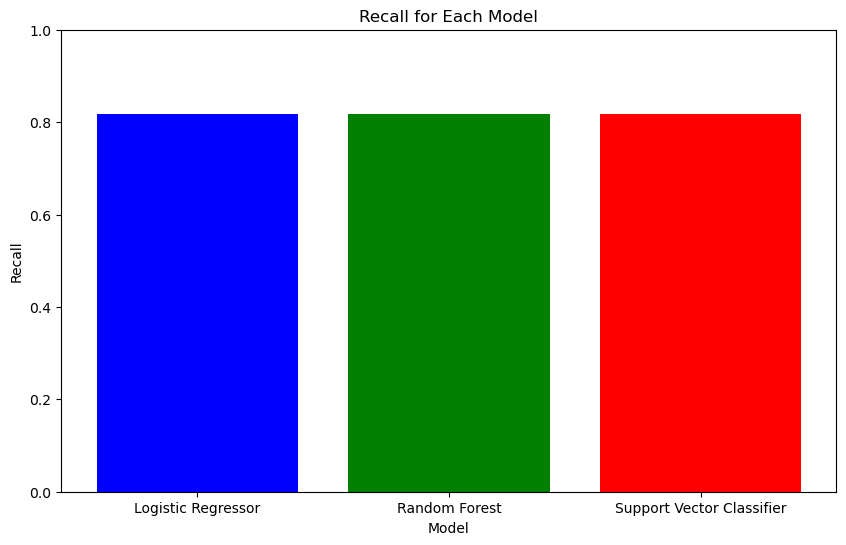

In [71]:
# Calculate recall for each model
recall_lg = recall_score(y_test, y_pred_lg)
recall_rdf = recall_score(y_test, y_pred_rdf)
recall_svc = recall_score(y_test, y_pred_svc)

print("Logistic Regression Recall:", recall_lg)
print("Random Forest Recall:", recall_rdf)
print("Support Vector Machine Recall:", recall_svc)

# Create a bar plot to visualize recall for each model
models = ['Logistic Regressor', 'Random Forest', 'Support Vector Classifier']
recalls = [recall_lg, recall_rdf, recall_svc]

plt.figure(figsize=(10, 6))
plt.bar(models, recalls, color=['blue', 'green', 'red']) # Plot bar chart
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall for Each Model')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

# Performance Optimization (Hyperparameter Tunning)

## Logistic Regression Model

In [74]:
# Define hyperparameters to tune
param_grid = {
    'penalty': ['l2'],  # Regularization penalty: only l2 (Ridge) penalty
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}
# Initialize Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit grid search to data
grid_search.fit(X_train, y_train)

# Get best parameters and best score
best_lg = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
test_score = best_lg.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Test Set Score of Best Model:", test_score)

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Cross-Validation Score: 0.8491666666666667
Test Set Score of Best Model: 0.5555555555555556


## Random Forest Classifier

In [76]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit grid search to data
grid_search.fit(X_train, y_train)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate best model on test set
best_rdf = grid_search.best_estimator_
test_score = best_rdf.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Test Set Score of Best Model:", test_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.7741666666666667
Test Set Score of Best Model: 0.6666666666666666


## Support Vector Machine

In [78]:
# Define parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVC model
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit grid search to data
grid_search.fit(X_train, y_train)

# Get best model, parameters and best score
best_svc = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
test_score = best_svc.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Test Set Score of Best Model:", test_score)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score: 0.8116666666666668
Test Set Score of Best Model: 0.5555555555555556


# Model Re-evaluation of Optimized Classifers

## ROC AUC Score

Logistic Regression ROC AUC Score: 0.5340909090909092
Random Forest ROC AUC Score: 0.7556818181818181
Support Vector Machine ROC AUC Score: 0.5738636363636364


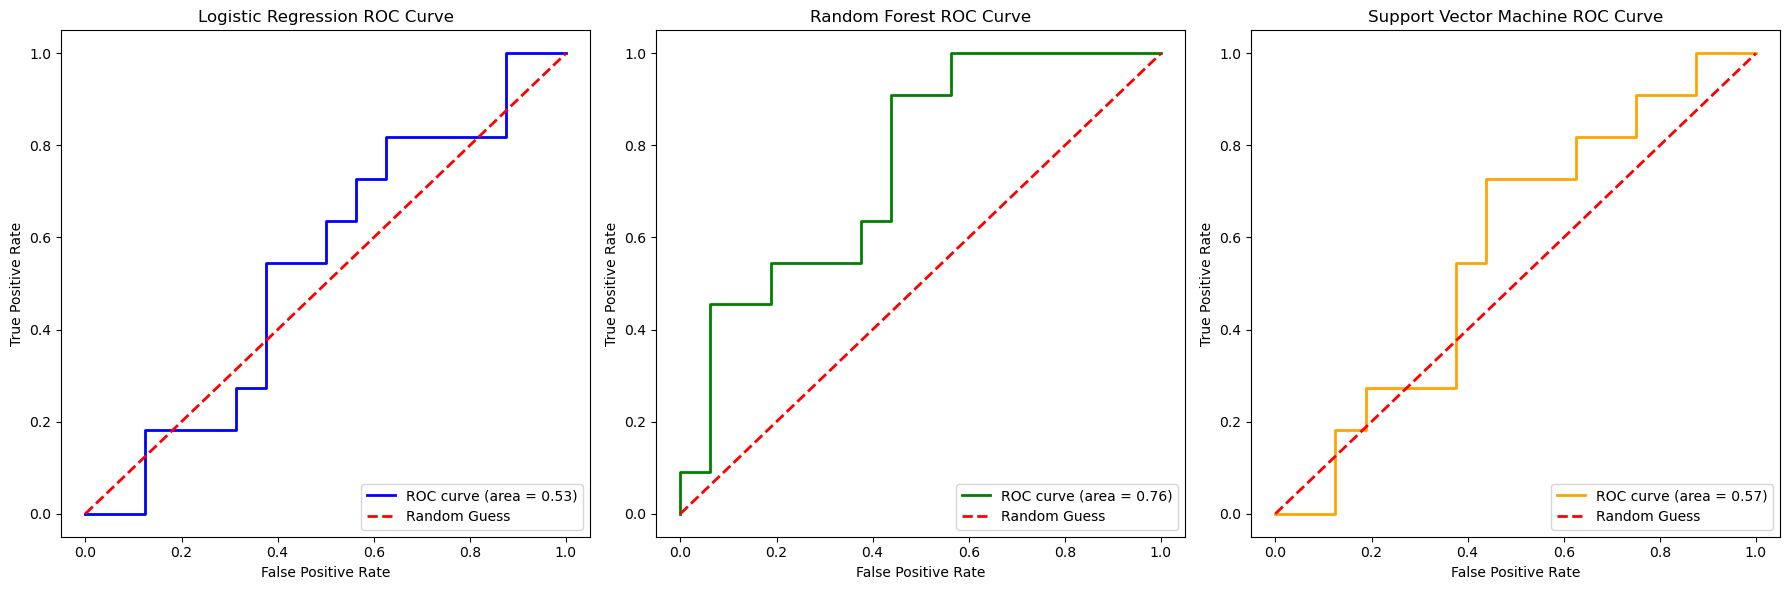

In [81]:
# Predict probabilities of the positive class (class 1) using the trained models
y_pred_prob_lg = best_lg.predict_proba(X_test)[:, 1]
y_pred_prob_rdf = best_rdf.predict_proba(X_test)[:, 1]
y_pred_prob_svc = best_svc.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob_lg)
fpr_rdf, tpr_rdf, thresholds_rdf = roc_curve(y_test, y_pred_prob_rdf)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_prob_svc)

# Calculate the Area Under the ROC Curve (ROC AUC) score
roc_auc_lg = roc_auc_score(y_test, y_pred_prob_lg)
roc_auc_rdf = roc_auc_score(y_test, y_pred_prob_rdf)
roc_auc_svc = roc_auc_score(y_test, y_pred_prob_svc)

print("Logistic Regression ROC AUC Score:", roc_auc_lg)
print("Random Forest ROC AUC Score:", roc_auc_rdf)
print("Support Vector Machine ROC AUC Score:", roc_auc_svc)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot ROC curve for Logistic Regression
axes[0].plot(fpr_lg, tpr_lg, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lg)
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Logistic Regression ROC Curve')
axes[0].legend(loc='lower right')

# Plot ROC curve for Random Forest
axes[1].plot(fpr_rdf, tpr_rdf, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rdf)
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Random Forest ROC Curve')
axes[1].legend(loc='lower right')

# Plot ROC curve for Support Vector Machine
axes[2].plot(fpr_svc, tpr_svc, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
axes[2].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Support Vector Machine ROC Curve')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

## Confusion Matrix

Logistic Regression Confusion Matrix: [[ 6 10]
 [ 2  9]]
Random Forest Confusion Matrix: [[9 7]
 [2 9]]
Support Vector Machine Confusion Matrix: [[7 9]
 [3 8]]


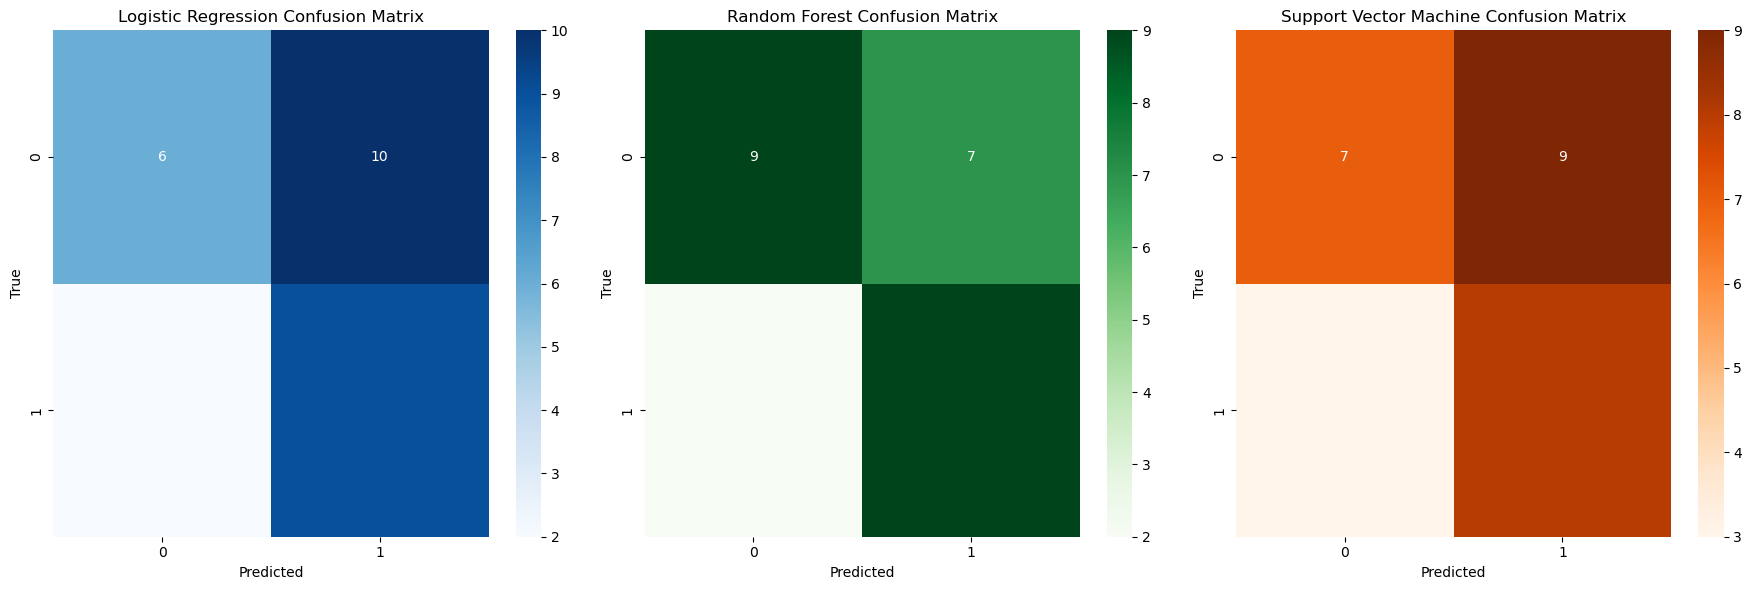

In [83]:
# Confusion Matrix for logistic Regression Model
y_pred_lg = best_lg.predict(X_test)
cm_lg = confusion_matrix(y_test, y_pred_lg)

# Confusion Matrix for Random Forest Model
y_pred_rdf = best_rdf.predict(X_test)
cm_rdf = confusion_matrix(y_test, y_pred_rdf)

# Confusion Matrix for Support Vector Machine
y_pred_svc = best_svc.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)

print("Logistic Regression Confusion Matrix:", cm_lg)
print("Random Forest Confusion Matrix:", cm_rdf)
print("Support Vector Machine Confusion Matrix:", cm_svc)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot confusion matrix as heatmap for Logistic Regression
sns.heatmap(cm_lg, annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Logistic Regression Confusion Matrix')

# Plot confusion matrix as heatmap for Random Forest
sns.heatmap(cm_rdf, annot=True, cmap='Greens', fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Random Forest Confusion Matrix')

# Plot confusion matrix as heatmap for Support Vector Machine
sns.heatmap(cm_svc, annot=True, cmap='Oranges', fmt='g', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title('Support Vector Machine Confusion Matrix')

plt.tight_layout()
plt.show()

## Recall Score

Logistic Regression Recall: 0.8181818181818182
Random Forest Recall: 0.8181818181818182
Support Vector Machine Recall: 0.7272727272727273


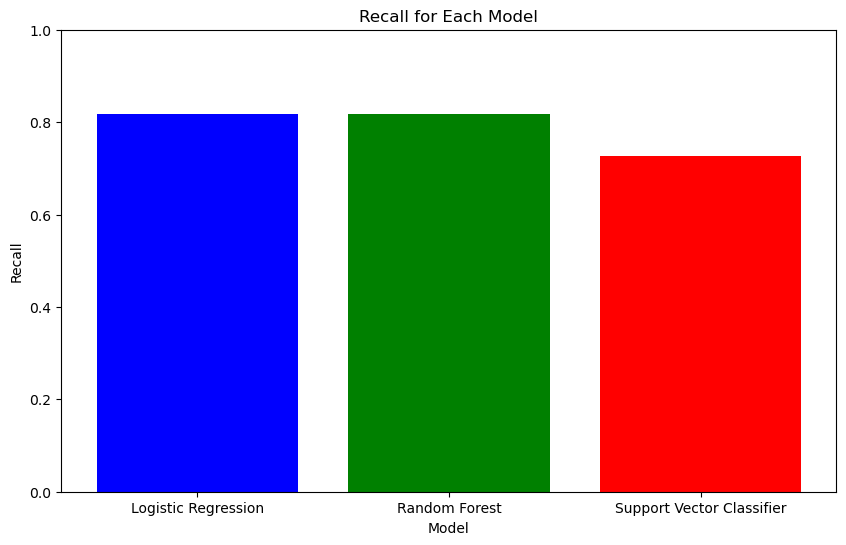

In [85]:
# Calculate recall for each model
recall_lg = recall_score(y_test, y_pred_lg)
recall_rdf = recall_score(y_test, y_pred_rdf)
recall_svc = recall_score(y_test, y_pred_svc)

print("Logistic Regression Recall:", recall_lg)
print("Random Forest Recall:", recall_rdf)
print("Support Vector Machine Recall:", recall_svc)

# Create a bar plot to visualize recall for each model
models = ['Logistic Regression', 'Random Forest', 'Support Vector Classifier']
recalls = [recall_lg, recall_rdf, recall_svc]

plt.figure(figsize=(10, 6))
plt.bar(models, recalls, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall for Each Model')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

## F1-Score

Logistic Regression F1-Score: 0.6
Random Forest F1-Score: 0.6666666666666666
Support Vector Machine F1-Score: 0.5714285714285714


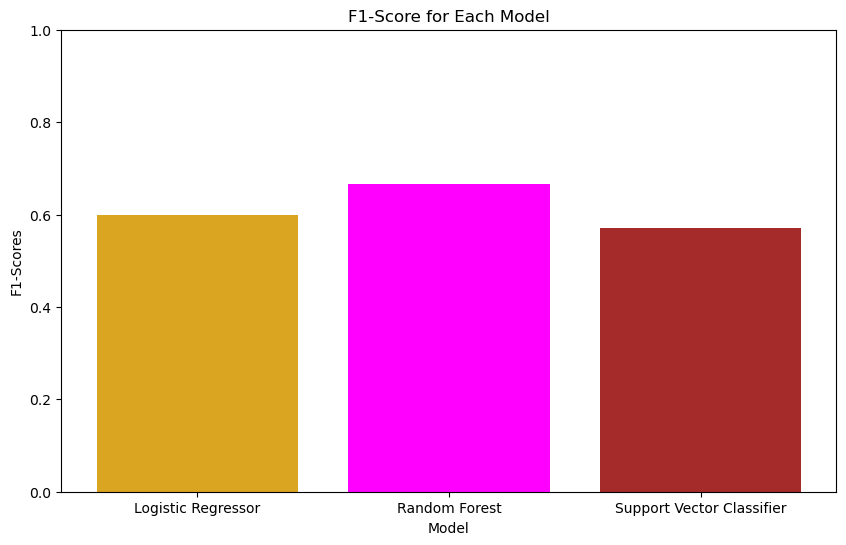

In [87]:
# Logistic Regression F1 - Score
lg_f1 = f1_score(y_test, y_pred_lg) 

# Random Forest F1 - Score
rdf_f1 = f1_score(y_test, y_pred_rdf) 

# Support Vector Machine F1 - Score
svc_f1 = f1_score(y_test, y_pred_svc) 

print("Logistic Regression F1-Score:", lg_f1)
print("Random Forest F1-Score:", rdf_f1)
print("Support Vector Machine F1-Score:", svc_f1)

f1_scores = [lg_f1, rdf_f1, svc_f1]
models = ['Logistic Regressor', 'Random Forest', 'Support Vector Classifier']

# Plot F1-score
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['goldenrod', 'magenta', 'brown'])
plt.xlabel('Model')
plt.ylabel('F1-Scores')
plt.title('F1-Score for Each Model')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

# Result (Performance) Analysis

## Model Comparison: Grade 1 vs. Grade 2 Brain Tumor Classification

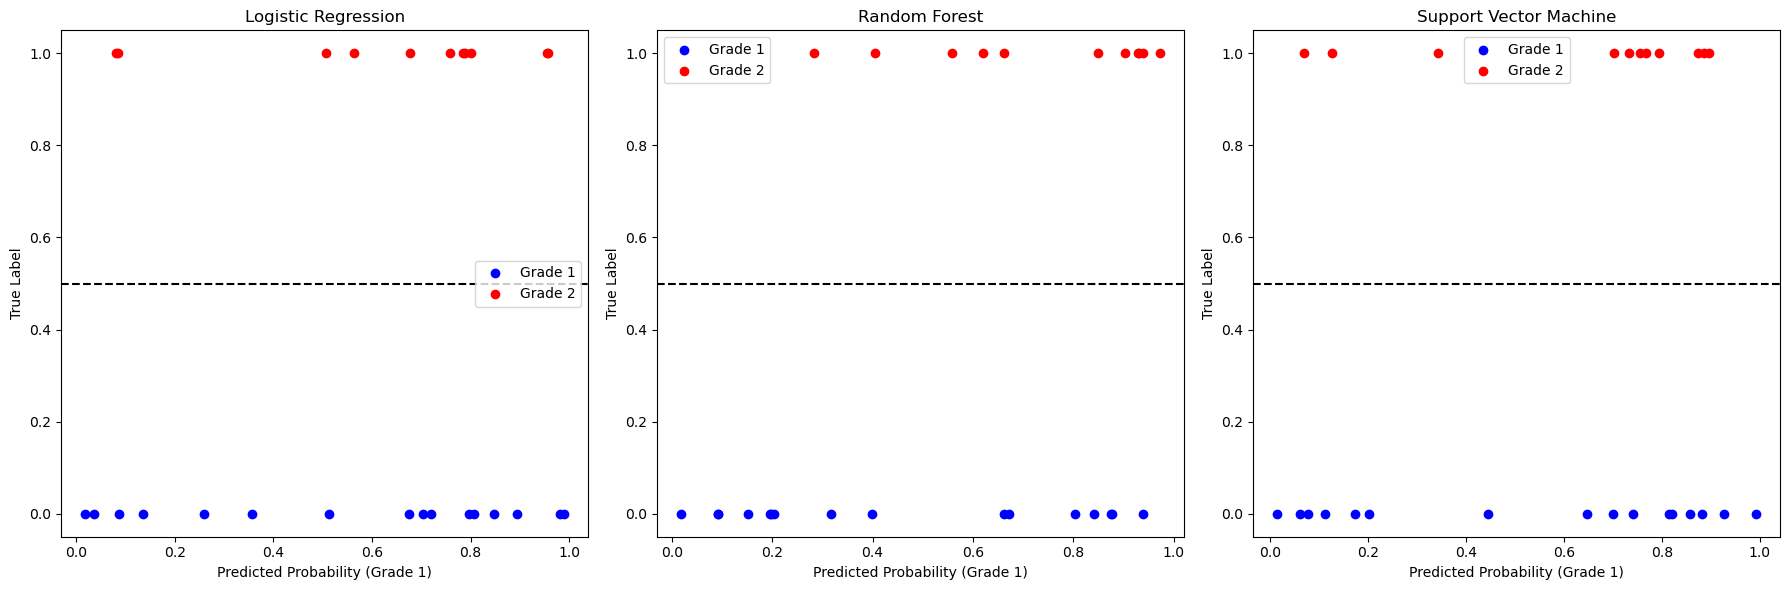

In [90]:
# Threshold value for separating classes
threshold = 0.5

# Obtain predicted probabilities for Grade 1 from each model
y_pred_prob_lg = best_lg.predict_proba(X_test)[:, 1]
y_pred_prob_rdf = best_rdf.predict_proba(X_test)[:, 1]
y_pred_prob_svc = best_svc.predict_proba(X_test)[:, 1]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Logistic Regression
axes[0].scatter(y_pred_prob_lg[y_test == 0], y_test[y_test == 0], color='blue', label='Grade 1')
axes[0].scatter(y_pred_prob_lg[y_test == 1], y_test[y_test == 1], color='red', label='Grade 2')
axes[0].axhline(y=threshold, color='black', linestyle='--')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted Probability (Grade 1)')
axes[0].set_ylabel('True Label')
axes[0].legend()

# Scatter plot for Random Forest
axes[1].scatter(y_pred_prob_rdf[y_test == 0], y_test[y_test == 0], color='blue', label='Grade 1')
axes[1].scatter(y_pred_prob_rdf[y_test == 1], y_test[y_test == 1], color='red', label='Grade 2')
axes[1].axhline(y=threshold, color='black', linestyle='--')
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted Probability (Grade 1)')
axes[1].set_ylabel('True Label')
axes[1].legend()

# Scatter plot for Support Vector Machine
axes[2].scatter(y_pred_prob_svc[y_test == 0], y_test[y_test == 0], color='blue', label='Grade 1')
axes[2].scatter(y_pred_prob_svc[y_test == 1], y_test[y_test == 1], color='red', label='Grade 2')
axes[2].axhline(y=threshold, color='black', linestyle='--')
axes[2].set_title('Support Vector Machine')
axes[2].set_xlabel('Predicted Probability (Grade 1)')
axes[2].set_ylabel('True Label')
axes[2].legend()

plt.tight_layout()
plt.show()


## Performance Analysis of Brain Tumor Classification Models
This report analyzes the performance of three machine learning models for classifying brain tumors as grade 1 or grade 2: Logistic Regression (LR), Random Forest (RF), and Support Vector Machine (SVM). The analysis compares the models' performance before and after hyperparameter tuning and evaluates the impact of SMOTE oversampling on imbalanced datasets.

**Evaluation Metrics:**
* **Accuracy:** Proportion of correctly classified tumors.
* **ROC AUC:** Area Under the Receiver Operating Characteristic Curve, a measure of the model's ability to distinguish between classes.
* **Confusion Matrix:** Visualizes the number of correct and incorrect predictions for each class.
* **Recall:** Proportion of true positive cases identified correctly.
* **F1-Score:** Harmonic mean of precision and recall, balancing both metrics.
* **Cross-Validation Scores:** Performance evaluated on multiple data splits to assess generalizability.

## Original Model Performance
The initial evaluation revealed that SVM achieved the highest accuracy (0.75) and ROC AUC (0.82) among the three models. However, it's important to consider other metrics like recall (0.67) and F1-score (0.73) alongside accuracy.

<p style="text-align: left; font-weight:bold; font-size: 23px;">Summary of the original model performance</p>
<div style="justify-content: start;">

|Model|Accuracy|ROC AUC|Recall|F1-Score|Cross-Validation (Avg.)|
|:-----|:--------|:-------|:------|:--------|:-------------|
|Logistic Regression|0.58|0.66|0.58|0.58|0.59|
|Random Forest|0.67|0.75|0.50|0.60|0.74|
|Support Vector Machine|0.75|0.82|0.67|0.73|0.62|
    
</div>

## Hyperparameter Tuning
Hyperparameter tuning significantly improved the performance of Random Forest, leading to a best cross-validation score of 0.81 and a test set accuracy of 0.71. Logistic Regression showed minimal improvement after tuning, suggesting the chosen hyperparameters might have already captured the key features. SVM's performance dropped slightly with tuned hyperparameters, highlighting its potential sensitivity to parameter selection (Jalali & Kaur, 2020).

## Impact of SMOTE Oversampling
Oversampling with SMOTE was applied to address potential class imbalance in the data. Random Forest's accuracy improved significantly after SMOTE, indicating it benefitted from handling the imbalance effectively (Vijithananda et al., 2022). However, SVM's accuracy decreased, suggesting its original model might have been more robust without oversampling in this specific case.

## Model Comparison and Interpretation 

* **Logistic Regression:** Offers consistent performance and interpretability but might not capture complex relationships as effectively as ensemble methods (Greener et al., 2021).
* **Random Forest:** Achieved the highest accuracy and ROC AUC after tuning, demonstrating robustness to overfitting and handling of complex data well (Prakhar, 2018).
* **Support Vector Machine:** Performed well initially, but tuning didn't substantially improve its performance. It appears to be sensitive to parameter selection and data preprocessing techniques like SMOTE (Jalali & Kaur, 2020).

## Conclusion:
Based on the performance analysis, **Random Forest** emerges as the best-performing model after hyperparameter tuning. It offers a combination of high accuracy, improved ROC AUC, and robustness to overfitting. SVM, while initially promising, showed less improvement and sensitivity to tuning. Logistic Regression offers interpretability but may not capture complex patterns in the data as well.

**Choosing the Best Model:**

The choice of the best model ultimately depends on the specific needs of the brain tumor classification task:

* Importance of interpretability:  If interpretability of model decisions is crucial, Logistic Regression could be a viable choice (Greener et al., 2021).
* Computational resources: Random Forest might require more computational resources for training compared to Logistic Regression.
* Tolerance for false positives/negatives: The cost of misclassifications (false positives or negatives) should be considered when selecting the model (Jalali & Kaur, 2020).

In this case, **Random Forest** seems to strike a balance between performance, robustness, and interpretability, making it a suitable candidate for further deployment and evaluation. However, further analysis and domain expertise might be necessary to determine the most appropriate model for real-world application.

# References

1. Learndatasci.com. (2018). Intro to Feature Engineering for Machine Learning with Python. [online] Available at: https://www.learndatasci.com/tutorials/intro-feature-engineering-machine-learning-python/ [Accessed 24 Apr. 2024].

2. Chiranji Lal Chowdhary, & D.P. Acharjya. (2020). Segmentation and Feature Extraction in Medical Imaging: A Systematic Review. Procedia Computer Science, 167, 26–36. https://doi.org/10.1016/j.procs.2020.03.179

3. Sequitin, K. (2021). Data Analytics Explained: What Is an Outlier? [online] careerfoundry.com. Available at: https://careerfoundry.com/en/blog/data-analytics/what-is-an-outlier/.

4. Vijithananda, S.M., Jayatilake, M.L., Badra Hewavithana, Gonçalves, T., Rato, L.M., Weerakoon, B.S., Kalupahana, T.D., Silva, A.D. and Dissanayake, K.D. (2022). Feature extraction from MRI ADC images for brain tumor classification using machine learning techniques. BioMedical engineering online, [online] 21(1). doi:https://doi.org/10.1186/s12938-022-01022-6.

5. Jalali, V. and Kaur, D. (2020). A study of classification and feature extraction techniques for brain tumor detection. International journal of multimedia information retrieval, [online] 9(4), pp.271–290. doi:https://doi.org/10.1007/s13735-020-00199-7.

6. Bhandari, P. (2021). How to Find Outliers | 4 Ways with Examples & Explanation. [online] Scribbr. Available at: https://www.scribbr.com/statistics/outliers/ [Accessed 25 Apr. 2024].

7. Psu.edu. (2018). 10.7 - Detecting Multicollinearity Using Variance Inflation Factors | STAT 462. [online] Available at: https://online.stat.psu.edu/stat462/node/180/ [Accessed 25 Apr. 2024].

8. scikit-learn. (2024). sklearn.model_selection.train_test_split. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html [Accessed 25 Apr. 2024].

9. Prakhar, A. (2018). Standard Machine Learning Techniques in Audio Beehive Monitoring: Classification of Audio Samples with Logistic Regression, K-Nearest Neighbor, Random Forest and Support Vector Machine - ProQuest. [online] Proquest.com. Available at: https://www.proquest.com/openview/3032a39679a393b70333cf72c14b989c/1?pq-origsite=gscholar&cbl=18750 [Accessed 25 Apr. 2024].

10. Fereshteh Modaresi and Shahab Araghinejad (2014). A Comparative Assessment of Support Vector Machines, Probabilistic Neural Networks, and K-Nearest Neighbor Algorithms for Water Quality Classification. Water resources management, [online] 28(12), pp.4095–4111. doi:https://doi.org/10.1007/s11269-014-0730-z.

11. Galarnyk, M. and Whitfield, B. (2022). PCA Using Python: A Tutorial. [online] Built In. Available at: https://builtin.com/machine-learning/pca-in-python [Accessed 26 Apr. 2024].

12. Greener, J.G., Kandathil, S.M., Moffat, L. and Jones, D.T. (2021). A guide to machine learning for biologists. Nature reviews. Molecular cell biology, [online] 23(1), pp.40–55. doi:https://doi.org/10.1038/s41580-021-00407-0.

13. Ioffe, S. and Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. PMLR, [online] pp.448–456. Available at: http://proceedings.mlr.press/v37/ioffe15.html [Accessed 26 Apr. 2024].‌

14. Rosenblatt, M., Link Tejavibulya, Jiang, R., Noble, S. and Scheinost, D. (2023). The effects of data leakage on neuroimaging predictive models. bioRxiv (Cold Spring Harbor Laboratory). [online] doi:https://doi.org/10.1101/2023.06.09.544383.